<a href="https://colab.research.google.com/github/GaoangLiu/ipynb/blob/master/Quora_Insincere_Questions_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Load packages 
import math
import re
import os
import timeit
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import logging
import time

from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
logging.basicConfig(format='[%(asctime)s %(levelname)8s] %(message)s', level=logging.INFO, datefmt='%m-%d %H:%M:%S')

from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential
from keras.layers import Flatten, Dense, Embedding, Dropout, LSTM, GRU, Bidirectional
from keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import gensim.downloader as api

# Get data
! rm *.csv
! wget -O quora.zip bwg.140714.xyz:8000/quora.zip 
! unzip quora.zip 
! ls 

In [0]:
# Base class for classifier
class Classifier():
  def __init__(self):
    self.train = None
    self.test = None 
    self.model = None

  def load_data(self, train_file='train.csv', test_file='test.csv'):
      """ Load train, test csv files and return pandas.DataFrame
      """
      self.train = pd.read_csv(train_file, engine='python', encoding='utf-8', error_bad_lines=False)
      self.test = pd.read_csv(test_file, engine='python', encoding='utf-8', error_bad_lines=False)
      logging.info('CSV data loaded')
  
  def countvectorize(self):
      tv = TfidfVectorizer(ngram_range=(1,3), token_pattern=r'\w{1,}',
               min_df=3, max_df=0.9, strip_accents='unicode', use_idf=1,
               smooth_idf=1, sublinear_tf=1, max_features=5000)
      tv = CountVectorizer()
      tv.fit(self.train.question_text)
      self.vector_train = tv.transform(self.train.question_text)
      self.vector_test  = tv.transform(self.test.question_text)
      logging.info("Train & test text tokenized")

  def build_model(self):
      pass

  def run_model(self):
      # Choose your own classifier: self.model and run it
      logging.info(f"{self.__class__.__name__} starts running.")
      labels = self.train.target
      x_train, x_val, y_train, y_val = train_test_split(self.vector_train, labels, test_size=0.2, random_state=2090)
      self.model.fit(x_train, y_train)
      y_preds = self.model.predict(x_val)

      logging.info(f"Accuracy score: {accuracy_score(y_val, y_preds)}")
      logging.info(f"Confusion matrix: ") 
      print(confusion_matrix(y_val, y_preds))
      print("Classificaiton report:\n", classification_report(y_val, y_preds, target_names=["Sincere", "Insincere"]))
      # y_preds = self.model.predict(self.vector_test)
      return y_preds

  def save_predictions(self, y_preds):
      sub = pd.read_csv(f"sample_submission.csv")
      sub['prediction'] = y_preds 
      sub.to_csv(f"submission_{self.__class__.__name__}.csv", index=False)
      logging.info('Prediction exported to submisison.csv')
  
  def pipeline(self):
      s_time = time.clock()
      self.load_data()
      self.countvectorize()
      self.build_model()
      self.save_predictions(self.run_model())
      logging.info(f"Program running for {time.clock() - s_time} seconds")

class C_Bayes(Classifier):
  def build_model(self):
      self.model = MultinomialNB()
      return self.model

# Logistic Regression 
class C_LR(Classifier):
  def build_model(self):
      self.model = LogisticRegression(n_jobs=10, solver='lbfgs', C=0.1, verbose=1)
      return self.model

class C_SVM(Classifier):
  def load_data(self, train_file='train.csv', test_file='test.csv'):
      """ Load train, test csv files and return pandas.DataFrame
      """
      self.train = pd.read_csv(train_file, engine='python', encoding='utf-8', error_bad_lines=False)
      self.train = self.train.sample(100000)
      self.test = pd.read_csv(test_file, engine='python', encoding='utf-8', error_bad_lines=False)
      logging.info('CSV data loaded')

  def build_model(self):
      self.model = svm.SVC()
      return self.model

class C_Ensemble(Classifier):
  def ensemble(self):
      s_time = time.perf_counter()
      self.load_data()
      self.countvectorize()

      nb = MultinomialNB()
      lr = LogisticRegression(n_jobs=10, solver='saga', C=0.1, verbose=1)
      svc = svm.SVC()

      all_preds = [0] * self.test.shape[0]
      for m in (nb, lr, svc):
          self.model = m
          if m == svc: 
              self.load_data()
              self.train = self.train.sample(10000)
              self.countvectorize()
          all_preds += self.run_model()

      all_preds = [1 if p > 0 else 0 for p in all_preds]
      self.save_predictions(all_preds)
      logging.info(f"Program running for {time.perf_counter() - s_time} seconds")


class Helper():
    def locate_threshold(self, model, x_val, y_val):
        y_probs = model.predict_proba(x_val, batch_size=1024, verbose=1)
        best_threshold = best_f1 = pre_f1 = 0
        history = []

        for i in np.arange(0.01, 1, 0.01):
          if len(y_probs[0]) >= 2:
              y2_preds = [1 if e[1] >= i else 0 for e in y_probs]
          else:
              y2_preds = (y_probs > i).astype(int)

          cur_f1 = f1_score(y_val, y2_preds)
          history.append((i, cur_f1))
          symbol = '+' if cur_f1 >= pre_f1 else '-'
          print("Threshold {:6.4f}, f1_score: {:<0.8f}  {} {:<0.6f} ".format(i, cur_f1, symbol, abs(cur_f1 - pre_f1)))
          pre_f1 = cur_f1

          if cur_f1 >= best_f1:
              best_f1 = cur_f1
              best_threshold = i

        print(f"Best f1 score {best_f1}, best threshold {best_threshold}")
        plt.xlabel('Threshold')
        plt.ylabel('f1_score')
        plt.plot(*zip(*history))

## CNN
We've tried linear models, the best result of private`f1_score` we got is 0.62166. Now we try Neural Network

2020.05.11 Biderectional GRU achieved `private_score` 0.64255, `public_score` 0.63140

Seems that, smaller `batch_size` produces better performance, both on `precision` and `f1_score` .



In [38]:
class C_NN(Classifier):
    def __init__(self, max_features=100000, embed_size=128, max_len=300):
        self.max_features=max_features
        self.embed_size=embed_size
        self.max_len=max_len
    
    def tokenize_text(self, text_train, text_test):
        '''@para: max_features, the most commenly used words in data set
        @input are vector of text
        '''
        tokenizer = Tokenizer(num_words=self.max_features)
        text = pd.concat([text_train, text_test])
        tokenizer.fit_on_texts(text)

        sequence_train = tokenizer.texts_to_sequences(text_train)
        tokenized_train = pad_sequences(sequence_train, maxlen=self.max_len)
        logging.info('Train text tokeninzed')

        sequence_test = tokenizer.texts_to_sequences(text_test)
        tokenized_test = pad_sequences(sequence_test, maxlen=self.max_len)
        logging.info('Test text tokeninzed')
        return tokenized_train, tokenized_test, tokenizer
      
    def build_model(self):
        dropout = 0.2
        model = Sequential()
        model.add(Embedding(self.max_features, self.embed_size, input_length=self.max_len))
        model.add(Bidirectional(GRU(64, return_sequences=True)))
        model.add(Bidirectional(GRU(64, return_sequences=True)))
        model.add(Flatten())

        model.add(Dense(32, activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(1, activation='sigmoid'))
        self.model = model

        return self.model
    def embed_glove_vector(self, word_index, model='glove-wiki-gigaword-100'):
        glove = api.load(model) # default: wikipedia 6B tokens, uncased
        zeros = [0] * self.embed_size
        matrix = np.zeros((self.max_features, self.embed_size))
          
        for word, i in word_index.items(): 
            if i >= self.max_features or word not in glove: continue # matrix[0] is zeros, that's also why >= is here
            matrix[i] = glove[word]

        logging.info('Glove embedding vector created')
        return matrix

    def run(self, x_train, y_train):
        checkpoint = ModelCheckpoint('weights_base_best.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='max')
        early = EarlyStopping(monitor="val_acc", mode="max", patience=5)

        self.model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
        X_tra, X_val, y_tra, y_val = train_test_split(x_train, y_train, train_size=0.8, random_state=2020)
        BATCH_SIZE = max(16, 2 ** int(math.log(len(X_tra) / 100, 2)))
        logging.info(f"Batch size is set to {BATCH_SIZE}")
        history = self.model.fit(X_tra, y_tra, epochs=2, batch_size=BATCH_SIZE, validation_data=(X_val, y_val), \
                              callbacks=[checkpoint, early], verbose=1)

        y_pred = self.model.predict(X_val, batch_size=64, verbose=1)
        y_pred_bool = np.argmax(y_pred, axis=1)
        print(classification_report(y_val, y_pred_bool))
        return history

c = C_NN(max_features=50000, embed_size=300, max_len=200)
c.load_data()
c.train = c.train[:300_000]
# c.test = c.test.sample(1000)
vector_train, vector_test, tokenizer = c.tokenize_text(c.train.question_text, c.test.question_text)
model = c.build_model()

# Embed pretrained word vector
# embed_matrix = c.embed_glove_vector(tokenizer.word_index, model='word2vec-google-news-300')
# model.layers[0].set_weights([embed_matrix])
# model.layers[0].trainable = False

[05-11 13:01:41     INFO] CSV data loaded
[05-11 13:02:01     INFO] Train text tokeninzed
[05-11 13:02:09     INFO] Test text tokeninzed


In [0]:
tmptrain = c.train
tmptrain.question_text.str.len().hist()
# ids = tmptrain[tmptrain.target == 0].sample(100).index
# vector_train[ids]


In [40]:
c.model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
# x_train, y_train = vector_train

X_tra, X_val, y_tra, y_val = train_test_split(vector_train, c.train.target, train_size=0.8, random_state=2020)
history = c.model.fit(X_tra, y_tra, epochs=1, batch_size=1024, validation_data=(X_val, y_val))

# y_pred = c.model.predict(X_val, batch_size=1024, verbose=1)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 240000 samples, validate on 60000 samples
Epoch 1/1
240000/240000 [==============================] - 772s 3ms/step - loss: 0.1334 - acc: 0.9473 - val_loss: 0.1226 - val_acc: 0.9518


60000/60000 [==============================] - 51s 842us/step
Threshold 0.0100, f1_score: 0.31470194  + 0.314702 
Threshold 0.0200, f1_score: 0.38574309  + 0.071041 
Threshold 0.0300, f1_score: 0.42870422  + 0.042961 
Threshold 0.0400, f1_score: 0.45812841  + 0.029424 
Threshold 0.0500, f1_score: 0.48137248  + 0.023244 
Threshold 0.0600, f1_score: 0.49744053  + 0.016068 
Threshold 0.0700, f1_score: 0.51243040  + 0.014990 
Threshold 0.0800, f1_score: 0.52583685  + 0.013406 
Threshold 0.0900, f1_score: 0.53641774  + 0.010581 
Threshold 0.1000, f1_score: 0.54499957  + 0.008582 
Threshold 0.1100, f1_score: 0.55287570  + 0.007876 
Threshold 0.1200, f1_score: 0.55937726  + 0.006502 
Threshold 0.1300, f1_score: 0.56643874  + 0.007061 
Threshold 0.1400, f1_score: 0.57196755  + 0.005529 
Threshold 0.1500, f1_score: 0.57656791  + 0.004600 
Threshold 0.1600, f1_score: 0.57980647  + 0.003239 
Threshold 0.1700, f1_score: 0.58388060  + 0.004074 
Threshold 0.1800, f1_score: 0.58752149  + 0.003641 
Th

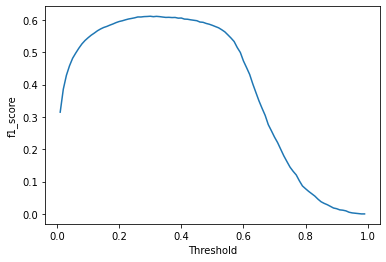

In [41]:
# Find maximum threshold 
Helper().locate_threshold(c.model, X_val, y_val)
# 300_000 train size, batch_size = 1024, f1_score = 0.6118
# 300_000 train size, batch_size = 1024, double GRU, f1_score = 0.6113
# 300_000 train size, batch_size = 1024, with glove-wiki-gigaword-100 embeding, f1_score = 0.6030
# 300_000 train size, batch_size = 1024, with google-news 300 embeding, f1_score = 0.6078
# full train, bsize 1024, embed_size=300, maxlen=200, google news 300, f1_score = 0.6404
# full train, bsize 1024, embed_size=300, maxlen=200, no embed, f1_score = 0.6390


# Logistic Regression 
Besides NB, we also tried LR to maximum `f1_score`

2020.05.09: 
* Set `threshold = 0.21`, we got public score 0.60627 + private score = 0.62161. Bot are the maximum score we've got by now.
<img class="center" src="https://i.loli.net/2020/05/09/eE4KqloW52FDSdc.png" alt="LR max f1_score" width=850>
* Set `threshold=0.25`, `public_score=0.60619` decreased, but `private_score=0.62166` increased. 


In [0]:
c = C_LR()
c.load_data()
# b.train = b.train.sample(100000)
c.countvectorize()
labels = c.train.target
x_train, x_val, y_train, y_val = train_test_split(c.vector_train, labels, test_size=0.2, random_state=2090)

model = LogisticRegression(n_jobs=10, solver='saga', C=0.1, verbose=1)
model.fit(x_train, y_train)
y_preds = model.predict(x_val)

print(f"Accuracy score: {accuracy_score(y_val, y_preds)}")
print(f"Confusion matrix: ") 
print(confusion_matrix(y_val, y_preds))
print("Classificaiton report:\n", classification_report(y_val, y_preds, target_names=["Sincere", "Insincere"]))

In [0]:
# Find the best threshold to maximum f1_score
Helper().locate_threshold(model, x_val, y_val)


# Naive Bayes
Since in this contest submissions are evaluated on **F1 Score** between the predicted and the observed targets. Our ultimate goal is to maximum the `f1_socre`. 

2020.05.09: 
* Naive Bayes achieved the maximum score `f1_score = 0.56456695` when the `threshold` is set to `0.726`. This result in a public score = 0.56452 + private score = 0.56706. The public socre is the best we've got with NB, but the private score is only second to 0.56889, one when we set the `threshold` to 0.6 .



In [0]:
b = C_Bayes()
b.load_data()
b.countvectorize()
b.build_model()
labels = b.train.target
x_train, x_val, y_train, y_val = train_test_split(b.vector_train, labels, test_size=0.2, random_state=2090)
b.model.fit(x_train, y_train)
y_preds = b.model.predict(x_val)

logging.info(f"Accuracy score: {accuracy_score(y_val, y_preds)}")
logging.info(f"Confusion matrix: ") 
print(confusion_matrix(y_val, y_preds))
print("Classificaiton report:\n", classification_report(y_val, y_preds, target_names=["Sincere", "Insincere"]))



In [0]:
# Find the best threshold to maximum f1_score
Helper().locate_threshold(b.model, x_val, y_val)